In [2]:
# Patient Sentiment Analysis - Training Pipeline
# Goal: Build a sentiment classifier for healthcare patient reviews

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import nltk

# Download required NLTK data
import nltk
nltk.download('stopwords')
nltk.download('punkt')

print("Setup complete!")

Setup complete!


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malvinsiew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/malvinsiew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Load dataset
df_train = pd.read_csv("../data/drugsComTrain_raw.csv")
df_test = pd.read_csv("../data/drugsComTest_raw.csv")

print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)
print("\nColumn names:")
print(df_train.columns.to_list())
print("\nFirst few rows:")
df_train.head()

Training set shape: (161297, 7)
Test set shape: (53766, 7)

Column names:
['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount']

First few rows:


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


Rating distribution in training data:
rating
1     21619
2      6931
3      6513
4      5012
5      8013
6      6343
7      9456
8     18890
9     27531
10    50989
Name: count, dtype: int64


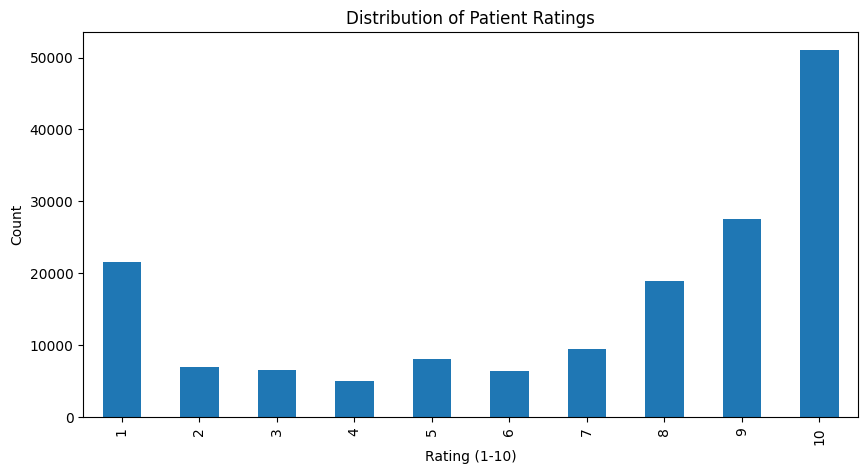


Mean rating: 6.99
Median rating: 8.0


In [4]:
# Explore the rating distribution
print("Rating distribution in training data:")
print(df_train['rating'].value_counts().sort_index())

# Visualise it
plt.figure(figsize=(10, 5))
df_train['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating (1-10)')
plt.ylabel('Count')
plt.title('Distribution of Patient Ratings')
plt.show()

# Summary statistics
print(f"\nMean rating: {df_train['rating'].mean():.2f}")
print(f"Median rating: {df_train['rating'].median()}")

Training set sentiment distribution:
sentiment
0    35063
1    28824
2    97410
Name: count, dtype: int64

Percentages:
sentiment
0    21.73816
1    17.87014
2    60.39170
Name: proportion, dtype: float64


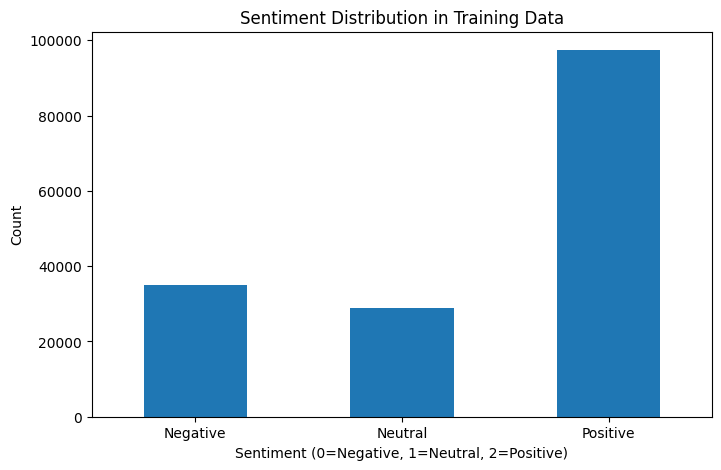

In [5]:
# Create sentiment labels based on rating
def rating_to_sentiment(rating):
    if rating <= 3:
        return 0  # Negative
    elif rating <= 7:
        return 1  # Neutral
    else:
        return 2  # Positive

# Apply to both train and test
df_train['sentiment'] = df_train['rating'].apply(rating_to_sentiment)
df_test['sentiment'] = df_test['rating'].apply(rating_to_sentiment)

# Check the distribution
print("Training set sentiment distribution:")
print(df_train['sentiment'].value_counts().sort_index())
print(f"\nPercentages:")
print(df_train['sentiment'].value_counts(normalize=True).sort_index() * 100)

# Visualize
plt.figure(figsize=(8, 5))
df_train['sentiment'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Sentiment (0=Negative, 1=Neutral, 2=Positive)')
plt.ylabel('Count')
plt.title('Sentiment Distribution in Training Data')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'], rotation=0)
plt.show()

In [6]:
# Look at sample reviews from each sentiment class
print("=" * 80)
print("NEGATIVE REVIEWS (rating 1-3):")
print("=" * 80)
for review in df_train[df_train['sentiment'] == 0]['review'].head(3):
    print(f"- {review[:200]}...\n")

print("=" * 80)
print("NEUTRAL REVIEWS (rating 4-7):")
print("=" * 80)
for review in df_train[df_train['sentiment'] == 1]['review'].head(3):
    print(f"- {review[:200]}...\n")

print("=" * 80)
print("POSITIVE REVIEWS (rating 8-10):")
print("=" * 80)
for review in df_train[df_train['sentiment'] == 2]['review'].head(3):
    print(f"- {review[:200]}...\n")

NEGATIVE REVIEWS (rating 1-3):
- "2nd day on 5mg started to work with rock hard erections however experianced headache, lower bowel preassure. 3rd day erections would wake me up &amp; hurt! Leg/ankles aches   severe lower bowel preas...

- "He pulled out, but he cummed a bit in me. I took the Plan B 26 hours later, and took a pregnancy test two weeks later - - I&#039;m pregnant."...

- " I Ve had  nothing but problems with the Keppera : constant shaking in my arms &amp; legs &amp; pins &amp; needles feeling in my arms &amp; legs severe light headedness no appetite &amp; etc."...

NEUTRAL REVIEWS (rating 4-7):
- "I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not availab...

- "I had Crohn&#039;s with a resection 30 years ago and have been mostly in remission since.  Have recently had a bad flare and narrowing at the anastomosis and need to be on m

In [7]:
import re
import html
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data if not already done
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Modified stop words (excluding negations)
stop_words = set(stopwords.words('english'))
negation_words = {'no', 'not', 'nor', 'never', 'none', 'nobody', 'nothing', 
                  'neither', 'nowhere', 'hardly', 'scarcely', 'barely', "don't",
                  "doesn't", "didn't", "won't", "wouldn't", "shouldn't", "cannot",
                  "can't", "couldn't", "isn't", "aren't", "wasn't", "weren't"}
stop_words = stop_words - negation_words

def preprocess_text(text):
    """
    Clean and preprocess review text
    """
    # 1. Decode HTML entities
    text = html.unescape(text)
    
    # 2. Convert to lowercase
    text = text.lower()
    
    # 3. Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # 4. Remove special characters, keep letters/numbers/spaces
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    
    # 5. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 6. Remove stop words (but keep negations!)
    tokens = text.split()
    tokens = [word for word in tokens 
              if (word not in stop_words) and (len(word) > 2 or word in negation_words)]
    
    
    # 7. Join back
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Test again on same review
sample_review = df_train.iloc[0]['review']
print("ORIGINAL:")
print(sample_review)
print("\nCLEANED:")
print(preprocess_text(sample_review))

ORIGINAL:
"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"

CLEANED:
no side effect take combination bystolic fish oil


In [8]:
# Apply preprocessing to all reviews
print("Preprocessing training data...")
df_train['cleaned_review'] = df_train['review'].apply(preprocess_text)

print("Preprocessing test data...")
df_test['cleaned_review'] = df_test['review'].apply(preprocess_text)

print("✓ Preprocessing complete!")

# Let's examine a few examples from each sentiment class
print("\n" + "="*80)
print("EXAMPLES OF CLEANED REVIEWS:")
print("="*80)

for sentiment, label in [(0, "NEGATIVE"), (1, "NEUTRAL"), (2, "POSITIVE")]:
    print(f"\n{label} (sentiment={sentiment}):")
    print("-"*80)
    sample = df_train[df_train['sentiment'] == sentiment].iloc[0]
    print(f"Original: {sample['review'][:150]}...")
    print(f"Cleaned:  {sample['cleaned_review'][:150]}...")

Preprocessing training data...
Preprocessing test data...
✓ Preprocessing complete!

EXAMPLES OF CLEANED REVIEWS:

NEGATIVE (sentiment=0):
--------------------------------------------------------------------------------
Original: "2nd day on 5mg started to work with rock hard erections however experianced headache, lower bowel preassure. 3rd day erections would wake me up &amp;...
Cleaned:  2nd day 5mg started work rock hard erections however experianced headache lower bowel preassure 3rd day erections would wake hurt leg ankles aches sev...

NEUTRAL (sentiment=1):
--------------------------------------------------------------------------------
Original: "I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it...
Cleaned:  used take another oral contraceptive pill cycle happy light periods max days no side effects contained hormone gestodene not available switched lybrel...

POSITIVE (sentimen

In [9]:
# Downloading Word2Vec for embedding
import gensim.downloader as api
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Download pre-trained Word2Vec embeddings (this will take a few minutes first time)
print("Downloading Word2Vec embeddings (this may take a few minutes)...")
word2vec_model = api.load("word2vec-google-news-300")
print("✓ Word2Vec loaded successfully!")

# Check it works - test similarity
print("\nTesting embeddings:")
print(f"'good' is similar to: {word2vec_model.most_similar('good', topn=3)}")
print(f"'terrible' is similar to: {word2vec_model.most_similar('terrible', topn=3)}")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/malvinsiew/miniconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/malvinsiew/miniconda3/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/malvinsiew/PycharmProjects/Datascience/patient_sentiment_analysis/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/malvinsiew/PycharmProjects/Datascience/patient_sentiment_analysis/v

✓ Word2Vec loaded successfully!

Testing embeddings:
'good' is similar to: [('great', 0.7291509509086609), ('bad', 0.7190050482749939), ('terrific', 0.688911497592926)]
'terrible' is similar to: [('horrible', 0.92439204454422), ('horrendous', 0.8467270135879517), ('dreadful', 0.8022767901420593)]


In [18]:
def review_to_average_embedding(review, word2vec_model, embedding_dim=300):
    """
    Convert a review (string of words) to a single averaged embedding vector.
    
    Args:
        review: String of space-separated words (already cleaned/preprocessed)
        word2vec_model: Pre-trained Word2Vec model
        embedding_dim: Dimension of embeddings (300 for Google News Word2Vec)
    
    Returns:
        numpy array of shape (300,) - averaged embedding for the entire review
    """
    words = review.split()
    
    # Collect embeddings for words that exist in Word2Vec vocabulary
    word_embeddings = []
    for word in words:
        if word in word2vec_model:
            word_embeddings.append(word2vec_model[word])
    
    # If no words found in vocabulary, return zero vector
    if len(word_embeddings) == 0:
        return np.zeros(embedding_dim)
    
    # Average all word embeddings into a single vector
    averaged_embedding = np.mean(word_embeddings, axis=0)
    return averaged_embedding

# Test the function
sample_review = df_train_sample.iloc[0]['cleaned_review']
sample_embedding = review_to_average_embedding(sample_review, word2vec_model)

print(f"Sample review: {sample_review}")
print(f"Embedding shape: {sample_embedding.shape}")  # Should be (300,)
print(f"First 10 values: {sample_embedding[:10]}")

Sample review: started taking phentermine little month ago weighing 307 doctor started half pill day immediately felt medicine start working jittery jumping skin feeling lot energy first days sweated profusely water side times felt meds even 5th day asking doctor let take whole pill day make sure take dose early first wake weeks dropped 293 drug life changing disability chronic pain medicine seemed help beyond appetite suppressant year old female hope
Embedding shape: (300,)
First 10 values: [ 0.00447515  0.09084753 -0.00297751  0.03815847 -0.02769151 -0.02089321
  0.04016113 -0.11658899  0.07355351  0.04063302]


In [19]:
from tqdm import tqdm

# Convert training reviews to averaged embeddings
print("Converting training reviews to averaged embeddings...")
X_train_averaged = []
for review in tqdm(df_train_sample['cleaned_review'], desc="Training"):
    X_train_averaged.append(review_to_average_embedding(review, word2vec_model))
X_train_averaged = np.array(X_train_averaged)

# Convert test reviews to averaged embeddings
print("\nConverting test reviews to averaged embeddings...")
X_test_averaged = []
for review in tqdm(df_test_sample['cleaned_review'], desc="Testing"):
    X_test_averaged.append(review_to_average_embedding(review, word2vec_model))
X_test_averaged = np.array(X_test_averaged)

# Get labels
y_train = df_train_sample['sentiment'].values
y_test = df_test_sample['sentiment'].values

print(f"\n✓ Embedding conversion complete!")
print(f"X_train_averaged shape: {X_train_averaged.shape}")  # Should be (16000, 300)
print(f"X_test_averaged shape: {X_test_averaged.shape}")    # Should be (5000, 300)
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Converting training reviews to averaged embeddings...


Training: 100%|██████████| 16000/16000 [00:02<00:00, 5418.99it/s] 



Converting test reviews to averaged embeddings...


Testing: 100%|██████████| 5000/5000 [00:00<00:00, 8807.68it/s] 


✓ Embedding conversion complete!
X_train_averaged shape: (16000, 300)
X_test_averaged shape: (5000, 300)
y_train shape: (16000,)
y_test shape: (5000,)


Training Logistic Regression model...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


✓ Training complete!

Test Accuracy: 0.5880 (58.80%)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.51      0.63      0.56      1156
     Neutral       0.31      0.45      0.36       919
    Positive       0.80      0.62      0.70      2925

    accuracy                           0.59      5000
   macro avg       0.54      0.56      0.54      5000
weighted avg       0.64      0.59      0.61      5000


Confusion Matrix:
[[ 726  253  177]
 [ 249  409  261]
 [ 455  665 1805]]


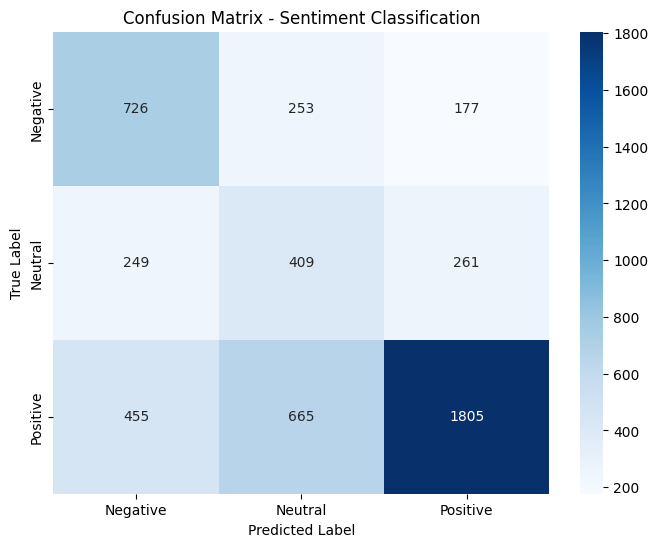

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Initialize logistic regression with class balancing
# (remember we have imbalanced classes: 60% positive, 22% negative, 18% neutral)
print("Training Logistic Regression model...")
model = LogisticRegression(
    max_iter=1000,           # Maximum iterations for convergence
    random_state=42,         # For reproducibility
    class_weight='balanced', # Handle class imbalance automatically
    verbose=1                # Show training progress
)

# Train the model
model.fit(X_train_averaged, y_train)

print("✓ Training complete!")

# Make predictions on test set
y_pred = model.predict(X_test_averaged)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Sentiment Classification')
plt.show()

In [24]:
import warnings
warnings.filterwarnings('ignore')

print("Starting hyperparameter tuning (with balanced classes fixed)...")
print("This will take a few minutes...\n")

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['lablinear', 'saga'],
    'max_iter': [1000, 2000]
}

# Create base model
base_model = LogisticRegression(
    random_state=42,
    class_weight='balanced'
)

# GridSearchCV
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,  # Changed to 1 for less verbose output
    n_jobs=-1
)

# Fit
grid_search.fit(X_train_averaged, y_train)

# Best parameters
print("\n" + "="*50)
print("BEST PARAMETERS FOUND (with balanced classes):")
print("="*50)
print(grid_search.best_params_)
print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_averaged)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

print(f"\nTest Accuracy (Tuned + Balanced): {accuracy_tuned:.4f} ({accuracy_tuned*100:.2f}%)")
print(f"Improvement over baseline: {(accuracy_tuned - accuracy)*100:.2f} percentage points")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, 
                          target_names=['Negative', 'Neutral', 'Positive']))

# Check confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned)
print("\nConfusion Matrix:")
print(cm)

# Check prediction distribution
from collections import Counter
print("\nPrediction distribution:")
print(Counter(y_pred_tuned))
print(f"True distribution:")
print(Counter(y_test))

Starting hyperparameter tuning (with balanced classes fixed)...
This will take a few minutes...

Fitting 5 folds for each of 40 candidates, totalling 200 fits



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/malvinsiew/miniconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/malvinsiew/miniconda3/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/malvinsiew/PycharmProjects/Datascience/patient_sentiment_analysis/venv/lib/python3.10/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 180, in <module>
    exitcode = process_obj._bootstrap()
  File "/Users/malvinsiew/miniconda3/lib/py


BEST PARAMETERS FOUND (with balanced classes):
{'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}

Best cross-validation accuracy: 0.5829

Test Accuracy (Tuned + Balanced): 0.5890 (58.90%)
Improvement over baseline: 0.10 percentage points

Classification Report:
              precision    recall  f1-score   support

    Negative       0.51      0.63      0.56      1156
     Neutral       0.31      0.44      0.36       919
    Positive       0.81      0.62      0.70      2925

    accuracy                           0.59      5000
   macro avg       0.54      0.56      0.54      5000
weighted avg       0.65      0.59      0.61      5000


Confusion Matrix:
[[ 732  250  174]
 [ 249  407  263]
 [ 455  664 1806]]

Prediction distribution:
Counter({np.int64(2): 2243, np.int64(0): 1436, np.int64(1): 1321})
True distribution:
Counter({np.int64(2): 2925, np.int64(0): 1156, np.int64(1): 919})
